<a href="https://colab.research.google.com/github/NandiniLReddy/ObjectRecognition_NextTokenPrediction/blob/main/ObjectRecognition_NextTokenPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## modified and deployed by Nandini Lokesh Reddy

In [1]:
! nvidia-smi

Thu Aug  1 06:16:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### **Re-Installing Packages**

In [2]:
# the packages will throw errors if keeping them
! pip uninstall --y torchaudio torchtext torchdata

# for torch + torchvision packages
! pip install torch==2.0.1 torchvision==0.15.2 --index-url https://download.pytorch.org/whl/cu118

# for training and inference
! pip install --no-cache-dir torchdata==0.6.1 fairscale nltk sentencepiece ftfy regex tqdm
! pip install --no-cache-dir git+https://github.com/openai/CLIP.git

# for evaluation
! pip install --no-cache-dir torchmetrics transformers

Found existing installation: torchaudio 2.3.1+cu121
Uninstalling torchaudio-2.3.1+cu121:
  Successfully uninstalled torchaudio-2.3.1+cu121
Found existing installation: torchtext 0.18.0
Uninstalling torchtext-0.18.0:
  Successfully uninstalled torchtext-0.18.0
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 739.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lit: filename=lit-15.0.7-py3-none-any.whl size=89990 sha256=f8ef6c81aa1645e969c737d54413fb22e0dbd6e8202624f90a2de234b8b60b19
  Stored in directory: /root/.cache/pip/wheels/27/2c/b6/3ed2983b1b44fe0dea1bb35234b09f2c22fb8ebb308679c922
Successfully built lit
  Attempting uninstall: triton
    Found e

In [3]:
import torch
import torchvision
import torchdata

print(torch.__version__, torchvision.__version__, torchdata.__version__)

2.0.1+cu118 0.15.2+cu118 0.6.1




---



### **0. Git-Clone The Repo**

In [4]:
! git clone https://github.com/KaiyuYue/nxtp.git

Cloning into 'nxtp'...
remote: Enumerating objects: 242, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 242 (delta 115), reused 180 (delta 63), pack-reused 0
Receiving objects: 100% (242/242), 30.47 MiB | 14.06 MiB/s, done.
Resolving deltas: 100% (115/115), done.


### **1. Inference**

This section will download the 1.78B model trained on G3M and predict labels for an image.

**1.1 Upload An Image**

This is optional for testing more images, please run this block to upload the images.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving coco_val_000000262938.jpg to coco_val_000000262938.jpg


**1.2 Pareparing LLaMA 2**

For inference (and evaluation), the model won't load the pretrained LLaMA weights.
Instead, it only needs the configuration file of model parameters, i.e., `params.json`.
We share it through the Google Drive for the quick test but encourge to have them from the [offical request precedure](https://github.com/facebookresearch/llama).

In [5]:
# mkdir dirs
! mkdir -p checkpoints
! mkdir -p checkpoints/llama-2
! mkdir -p checkpoints/llama-2/llama-2-7b

# download tokenizer.model
! gdown --fuzzy https://drive.google.com/file/d/1YbcECGKPf0nx9zGE5KUFB5FgLIN1nXp3/view?usp=drive_link
! mv tokenizer.model checkpoints/llama-2

# download LLaMA 7B's params.json
! gdown --fuzzy https://drive.google.com/file/d/1eO1-OUv2VVIRvqZPA40_dI-hZwdJT-6t/view?usp=drive_link
! mv params.json checkpoints/llama-2/llama-2-7b

# download checkpoint trained on G3M
! gdown --fuzzy https://drive.google.com/file/d/1QYT7kXD9qks6rQh0m2PnVlnSffj8VXNh/view
! md5sum /content/ckpt_epoch_03_iter_0021360.pth
! mv /content/ckpt_epoch_03_iter_0021360.pth /content/checkpoints

Downloading...
From: https://drive.google.com/uc?id=1YbcECGKPf0nx9zGE5KUFB5FgLIN1nXp3
To: /content/tokenizer.model
100% 500k/500k [00:00<00:00, 138MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eO1-OUv2VVIRvqZPA40_dI-hZwdJT-6t
To: /content/params.json
100% 102/102 [00:00<00:00, 471kB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1QYT7kXD9qks6rQh0m2PnVlnSffj8VXNh
From (redirected): https://drive.google.com/uc?id=1QYT7kXD9qks6rQh0m2PnVlnSffj8VXNh&confirm=t&uuid=6ba7f2f9-39ee-4250-b504-51bbc0b57bc9
To: /content/ckpt_epoch_03_iter_0021360.pth
100% 3.11G/3.11G [00:43<00:00, 71.9MB/s]
b2a69b3871cd1f9ba92e0f613edbe1ed  /content/ckpt_epoch_03_iter_0021360.pth


**1.3 Setting `data_root` in Config**

In [ ]:
! sed -i '14s/.*/    data_root: str = "\/content"/' /content/nxtp/src/configs/config_base.py

Or we can manually modify it by opening the file `nxtp/src/configs/config_base.py` in the left-side panel of Files browser.

dev_root = "/content/"

**1.4 Run**

In [8]:
# infer the demo image from the repo
! cd nxtp && python src/infer.py --ckpt-path /content/checkpoints/ckpt_epoch_03_iter_0021360.pth --img-path /content/testing.png --num-labels 20

LLaMA model params: {'dim': 4096, 'n_layers': 32, 'n_heads': 32, 'n_kv_heads': None, 'vocab_size': -1, 'multiple_of': 256, 'ffn_dim_multiplier': None, 'norm_eps': 1e-05, 'max_seq_len': 512}
Reloaded SentencePiece model from /content/checkpoints/llama-2/tokenizer.model
LLaMA tokenizer info: self.n_words: 32000, self.bos_id: 1, self.eos_id: 2, self.pad_id: -1
- add special tokens: {32000: '<|image|>', 32001: '<|empty|>'}
- self.n_special_tokens: 2
- self.n_words: 32002
inference mode is on, skip loading pre-trained checkpoints of LLaMA
loading checkpoint from /content/checkpoints/ckpt_epoch_03_iter_0021360.pth
total params: 1783.84 M, 1.78 B
/usr/local/lib/python3.10/dist-packages/torch/nested/__init__.py:58: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  return torch._nested_tensor_from_tensor_list(tensor_list, dtype, None, device, None)

inference time: 2.929

In [9]:
# infer the uploaded image coco_val_000000262938.jpg
! cd nxtp && python src/infer.py --ckpt-path /content/checkpoints/ckpt_epoch_03_iter_0021360.pth --img-path /content/testing2.png --num-labels 20

LLaMA model params: {'dim': 4096, 'n_layers': 32, 'n_heads': 32, 'n_kv_heads': None, 'vocab_size': -1, 'multiple_of': 256, 'ffn_dim_multiplier': None, 'norm_eps': 1e-05, 'max_seq_len': 512}
Reloaded SentencePiece model from /content/checkpoints/llama-2/tokenizer.model
LLaMA tokenizer info: self.n_words: 32000, self.bos_id: 1, self.eos_id: 2, self.pad_id: -1
- add special tokens: {32000: '<|image|>', 32001: '<|empty|>'}
- self.n_special_tokens: 2
- self.n_words: 32002
inference mode is on, skip loading pre-trained checkpoints of LLaMA
loading checkpoint from /content/checkpoints/ckpt_epoch_03_iter_0021360.pth
total params: 1783.84 M, 1.78 B
/usr/local/lib/python3.10/dist-packages/torch/nested/__init__.py:58: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  return torch._nested_tensor_from_tensor_list(tensor_list, dtype, None, device, None)

inference time: 1.756

In [10]:
# infer the demo image from the repo
! cd nxtp && python src/infer.py --ckpt-path /content/checkpoints/ckpt_epoch_03_iter_0021360.pth --img-path /content/mriScan.jpg --num-labels 5

LLaMA model params: {'dim': 4096, 'n_layers': 32, 'n_heads': 32, 'n_kv_heads': None, 'vocab_size': -1, 'multiple_of': 256, 'ffn_dim_multiplier': None, 'norm_eps': 1e-05, 'max_seq_len': 512}
Reloaded SentencePiece model from /content/checkpoints/llama-2/tokenizer.model
LLaMA tokenizer info: self.n_words: 32000, self.bos_id: 1, self.eos_id: 2, self.pad_id: -1
- add special tokens: {32000: '<|image|>', 32001: '<|empty|>'}
- self.n_special_tokens: 2
- self.n_words: 32002
inference mode is on, skip loading pre-trained checkpoints of LLaMA
loading checkpoint from /content/checkpoints/ckpt_epoch_03_iter_0021360.pth
total params: 1783.84 M, 1.78 B
/usr/local/lib/python3.10/dist-packages/torch/nested/__init__.py:58: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  return torch._nested_tensor_from_tensor_list(tensor_list, dtype, None, device, None)

inference time: 0.568

### **2. Evaluation on COCO Val**

This section shows how to evaluate the model on COCO validation split.

**2.1 Downloaing COCO Validation Split**

In [ ]:
# download COCO val2017 and annotations
! wget http://images.cocodataset.org/zips/val2017.zip
! wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# unzip
! unzip -qq -o val2017.zip
! unzip -qq -o annotations_trainval2017.zip

# mv
! mkdir -p coco && mv val2017 coco && mv annotations coco

# reorganize folders to webdatasets
! python nxtp/src/data/mscoco_to_wds.py /content/coco
! cd /content/coco/coco_valid/00000 && tar -cf ../00000.tar *
! cd /content/coco/coco_valid/00001 && tar -cf ../00001.tar *

--2023-12-05 04:38:45--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.43.89, 3.5.8.111, 52.217.232.169, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.43.89|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  85.9MB/s    in 10s     

2023-12-05 04:38:55 (75.6 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

--2023-12-05 04:38:55--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.235.225, 16.182.98.105, 3.5.29.219, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.235.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100

**2.2 Setting in Config**

- need to set a running mode without torch ddp due to a cudnn issue on colab, the config variable is `jupyter_mode = bool(1)`;
- need to set the `batch_size = 1`;
- need to set the `benchmark_infer_time = bool(0)` for a short logging output;
- need to change ranking method to `prob` to show the probability.

We can add all these settings in the file of `nxtp/src/evals/eval.py` for the local settings that won't affect the training part.

In [ ]:
! sed -i '29s/.*/    args.batch_size = 1/' /content/nxtp/src/evals/eval.py
! sed -i '49s/.*/    args.benchmark_infer_time = bool(0)/' /content/nxtp/src/evals/eval.py
! sed -i '56s/.*/    args.jupyter_mode = bool(1)  # disable ddp/' /content/nxtp/src/evals/eval.py
! sed -i '38s/.*/    args.ranking_method = "prob"  # clip, sim, ppl, prob, none/' /content/nxtp/src/evals/eval.py

- need to set the path to the downloaded model with `eval_ckpt_path`


In [ ]:
! sed -i '82s/.*/cfg.eval_ckpt_path: str = "\/content\/checkpoints\/ckpt_epoch_03_iter_0021360.pth"/' /content/nxtp/src/configs/config_g3m.py

**2.3 Run Evaluation**

In [ ]:
! cd nxtp/src && ./scripts/run eval_hook.py evals/eval.py configs/config_g3m.py

+ INPUT_ARGVS: evals/eval.py configs/config_g3m.py
+ NGPUS: 1
+ torchrun --rdzv-endpoint=localhost:12311 --nnode 1 --nproc_per_node 1 eval_hook.py evals/eval.py configs/config_g3m.py
use clip to rank topk: False
k_for_topk: 10
xk_for_one_shot_sampling: 0
ranking_method: prob
text_decoder_strategy: one_shot
eval on coco_valid
[nltk_data] Downloading package punkt to
[nltk_data]     /content/checkpoints/cache/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to
[nltk_data]     /content/checkpoints/cache/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /content/checkpoints/cache/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /content/checkpoints/cache/nltk_data...
enable ddp: False
tokenizer_config.json: 100% 350/350 [00:00<00:00, 1.42MB/s]
vocab.txt: 100% 232k/232k [00:0

**2.4 Check Predictions**

The predictions are saved in a file, `/content/checkpoints/results/coco_valid_rank-0_0.0.1.g3m.slm1b.llama2_prompt_list_one_shot_gen_64_tokens_prob_top10.res`, we can check out the results and other details in this file, for example, we can `cat` out the results for an image:

In [ ]:
! awk -v n=$(grep -n '000000262938' /content/checkpoints/results/coco_valid_rank-0_0.0.1.g3m.slm1b.llama2_prompt_list_one_shot_gen_64_tokens_prob_top10.res | cut -d: -f1) 'NR >= n && NR <= n+6' /content/checkpoints/results/coco_valid_rank-0_0.0.1.g3m.slm1b.llama2_prompt_list_one_shot_gen_64_tokens_prob_top10.res

path: /content/coco/coco_valid/00000/000000262938.jpg
tgts: ['blanket', 'book', 'picture', 'animal', 'stuffed', 'picture', 'dog']
vocs: dog	0.271,	book	0.0537,	animal	0.0494,	bed	0.0324,	friend	0.0172,	picture	0.0115,	life	0.0112,	puppy	0.011,	cover	0.0097,	pet	0.0092,	
scores: [[0.343994140625, 0.279296875, 0.316162109375, 0.376953125, 0.2252197265625, 0.265380859375, 0.232177734375, 0.377197265625, 0.55859375, 0.360107421875], [0.39453125, 1.0, 0.40771484375, 0.38037109375, 0.3037109375, 0.323486328125, 0.3916015625, 0.326416015625, 0.42236328125, 0.336669921875], [0.431396484375, 0.323486328125, 0.427490234375, 0.308837890625, 0.329345703125, 1.0, 0.412841796875, 0.40185546875, 0.392578125, 0.353515625], [0.8154296875, 0.40771484375, 1.0, 0.297119140625, 0.310302734375, 0.427490234375, 0.408935546875, 0.6845703125, 0.29736328125, 0.7568359375], [0.386474609375, 0.249755859375, 0.3759765625, 0.37744140625, 0.236328125, 0.343017578125, 0.27099609375, 0.426025390625, 0.392333984375, 0.

where
- `path`: the absolute path of the image
- `tgts`: reference labels from the raw captions
- `vocs`: predictions from the 1.78B model
- `scores`: BERTScore matrix between the `tgts` and `vocs`
- `div_scores`: the BERTScores between the `vocs` and `vocs` to measure the inner statistics, e.g., variance

So the top-10 predictions are:

`[dog	0.271, book 0.0537, animal 0.0494, bed 0.0324, friend 0.0172, picture 0.0115, life 0.0112, puppy 0.011, cover 0.0097, pet 0.0092]`




**Note**:
The number following the label, for example, `dog 0.271`, is a placeholder for values of `prob`, `ppl`, `sim`, or `clip score` by setting `args.ranking_method` in the `/content/nxtp/src/evals/eval.py`. `0.0` means `ranking_method = none`. Now it is `prob` in default with the latest code.

To visualize this image `/content/coco/coco_valid/00000/000000262938.jpg`

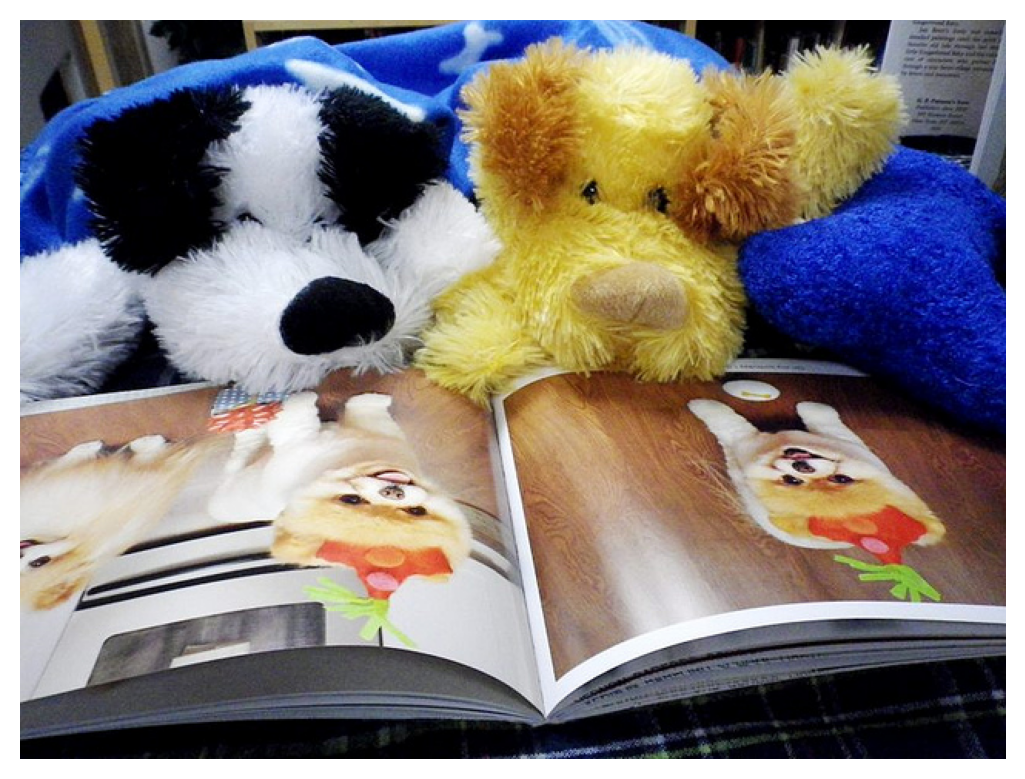

In [ ]:
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

image_path = "/content/coco/coco_valid/00000/000000262938.jpg"
img = Image.open(image_path).convert("RGB")
plt.imshow(img)
plt.axis("off")
plt.show()